In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../data_modules')
import spikeoutputs as so
import spikeplots as sp
import meaqc

Here I am loading a dataset from my SSD. Feel free to load this same one from the NAS array or any different one.

In [8]:
str_experiment = '20240717C'
d_meta = {'str_experiment': str_experiment,
          'str_algo': 'kilosort2.5',
          'paramsfile': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5.params',
          'dataset_name': 'kilosort2.5',
          'str_classification': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/vr_kilosort2.5.classification.txt',
          'ls_RGC_labels': ['OffP', 'OffM', 'OnP', 'OnM'],
          'ls_filenames': ['data014'],
          'ls_noise_filenames': ['data012'],
          'paramsmatfile': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5_params.mat'}
data = so.SpikeOutputs(**d_meta)
data.load_sta_from_params(load_ei=True, load_neurons=True, isi_bin_edges=np.linspace(0,300,601))

Loading STA from /Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5.params...
Loaded STA for 458 cells.
Loading STA params from /Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5_params.mat...
Loaded STA params for 458 cells.
Loading STA ISI...
Loading ISI for manookinlab.protocols.SpatialNoise ['data012']...
Processing group 1 of 1 and block 1 of 1
Loaded ISI for 458 cells.


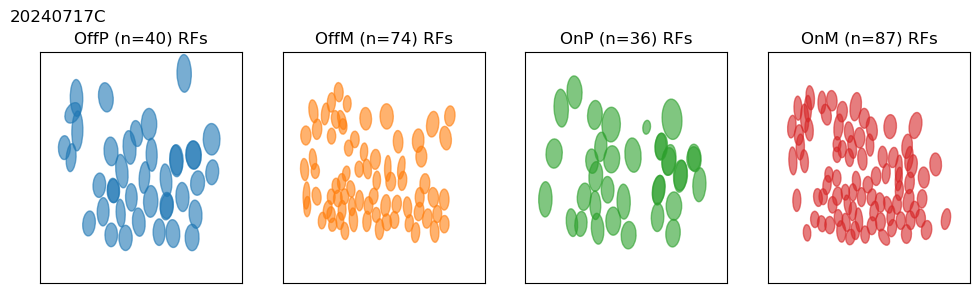

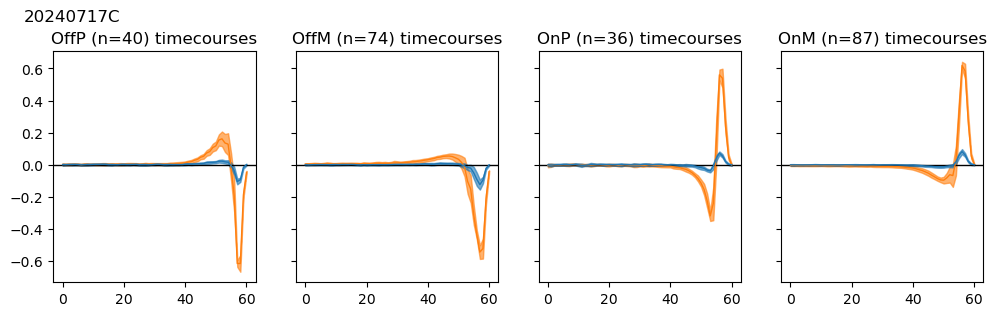

In [9]:
sp.plot_type_rfs(data, sd_mult=0.8, b_zoom=True);
sp.plot_type_tcs(data);

In [10]:
# Load psth of my protocol of interest
data.load_psth('PresentJitterImages', ['fileFolder', 'image_name', 'jitterX', 'jitterY'])

Processing group 1 of 1 and block 1 of 1
Loading ISI for PresentJitterImages ['data014']...
Processing group 1 of 1 and block 1 of 1
Loaded ISI for 589 cells.


In [11]:
data.print_stim_summary()

epoch length: 750.0 ms
Total epochs: 551
pre: 250.0 ms; stim: 250.0 ms; tail: 250.0 ms
pre pts: 25; stim pts: 25; tail pts: 25
bin rate: 100.0 Hz; bin dt: 10.0 ms


## QC object demo
Here I use the QC class from meaqc.py for filtering cells based on #sps and ISI violations.

In [12]:
qc = meaqc.QC(data)

Using first 3 bins for refractory period calculation.
isi_bins: [[0.  0.5]
 [0.5 1. ]
 [1.  1.5]]
458 noise cells, 589 protocol cells, 236 cells with >0 sps in both.
OffP: 40 noise, 23 protocol, 23 both.
OffM: 74 noise, 36 protocol, 36 both.
OnP: 36 noise, 19 protocol, 19 both.
OnM: 87 noise, 46 protocol, 45 both.
Updating GOOD_CELL_IDS to 236 cells.
OffP: 23/40
OffM: 36/74
OnP: 19/36
OnM: 45/87


The QC object on initialization found the cell IDs with >0 spikes in both the protocol and noise run, and updated `data.GOOD_CELL_IDS` accordingly.

Initializing the QC object will populate a `df_qc` table with properties of interest for each cell. 

Also currently, the initialization has hardcoded 1.5ms as the refractory period, based on which it sums the ISI for the 3 printed bins for calculating % refractory spikepairs.

In [13]:
qc.df_qc.head()

,cell_type,noise_spikes,noise_isi_violations,crf_f1,ei_corr,protocol_spikes,protocol_isi_violations
cell_id,,,,,,,
4,OnM,49815,0.0,NaN,NaN,1613,0.0
10,OffP,62857,0.0064,NaN,NaN,2364,0.0
11,All/big/,32980,0.003123,NaN,NaN,1126,0.0
14,All/big/,11943,0.0,NaN,NaN,2374,0.0
16,OffM,59224,0.001723,NaN,NaN,1667,0.0


crf_f1 and ei_corr are not populated by default currently.

We can look at the distributions of noise_spikes and noise_isi_violations.

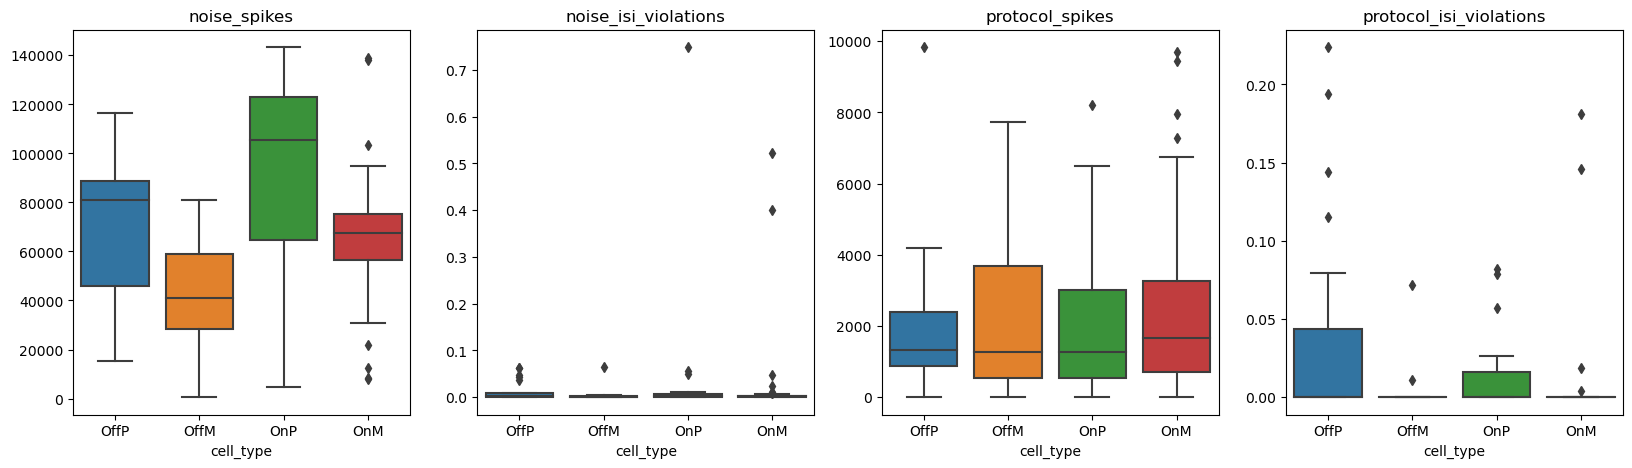

In [14]:
ls_params = ['noise_spikes', 'noise_isi_violations', 'protocol_spikes', 'protocol_isi_violations']
f, axs = plt.subplots(1, len(ls_params), figsize=(5*len(ls_params), 5))
for i, param in enumerate(ls_params):
    qc.plot_dist_by_type(param, axs[i])

The QC object has a dictionary for storing sets of thresholds and their consequences. By default, it is initialized with one set labeled 'set1'.

`qc.d_thresh['set1']` itself will be a dictionary containing user-set threshold values and a `df_keep` dataframe that will be populated with 0s and 1s based on thresholds.

In [15]:
qc.d_thresh.keys()

dict_keys(['set1'])

In [16]:
qc.d_thresh['set1']['df_keep'].head()

,cell_type,noise_spikes,noise_isi_violations,crf_f1,ei_corr,protocol_spikes,protocol_isi_violations
cell_id,,,,,,,
4,OnM,False,False,False,False,False,False
10,OffP,False,False,False,False,False,False
11,All/big/,False,False,False,False,False,False
14,All/big/,False,False,False,False,False,False
16,OffM,False,False,False,False,False,False


## Threshold Method 1
The QC object has 2 methods for setting thresholds: 
- `set_abs_thresh`: for a specified parameter in `df_qc`, split cells based on the input `n_thresh` value. If `b_keep_below` is true than cells below the value are kept, otherwise cells above the value are kept.

In [17]:
# Keep only cells that have less than 0.01% noise ISI violations
qc.set_abs_thresh('set1', 'noise_isi_violations', 0.01, b_keep_below=True)

Setting noise_isi_violations threshold at < 0.01.
199/458 total cells kept.


,n_good,n_total,pct
cell_type,,,
OffP,18,23,0.78
OffM,35,36,0.97
OnP,15,19,0.79
OnM,40,45,0.89


In [18]:
qc.set_abs_thresh('set1', 'protocol_isi_violations', 0.01)

Setting protocol_isi_violations threshold at < 0.01.
191/458 total cells kept.


,n_good,n_total,pct
cell_type,,,
OffP,16,23,0.70
OffM,34,36,0.94
OnP,13,19,0.68
OnM,42,45,0.93


Now `d_thresh` will have a dictionary for that parameter with the thresholds used and summary consequences for each cell type.

## Threshold method 2
- `set_pct_thresh_by_type`: for a specified parameter in `df_qc`, keep the top `n_top_pct` percent of cells within each cell type.

In [ ]:
qc.set_pct_thresh_by_type('set1', 'noise_spikes', n_top_pct=80)

Setting noise_spikes top 80 percentile threshold.


,n_good,n_total,pct,cutoff
cell_type,,,,
OffP,18,23,0.78,44828.6
OffM,28,36,0.78,23110.0
OnP,15,19,0.79,47487.0
OnM,36,45,0.80,53275.0


In [ ]:
qc.set_pct_thresh_by_type('set1', 'protocol_spikes', 80)

Setting protocol_spikes top 80 percentile threshold.


,n_good,n_total,pct,cutoff
cell_type,,,,
OffP,18,23,0.78,623.4
OffM,28,36,0.78,418.0
OnP,15,19,0.79,483.2
OnM,36,45,0.80,499.8


## Keep only good cell IDs

Let's update `data.GOOD_CELL_IDS` with the qc function `update_ids` that takes in the list of paramters to consider and the parameter set.

In [21]:
qc.update_ids(['noise_isi_violations', 'protocol_isi_violations', 'noise_spikes', 'protocol_spikes'],
              'set1')

Updating GOOD_CELL_IDS to 57 cells.
OffP: 8/23
OffM: 19/36
OnP: 6/19
OnM: 24/45


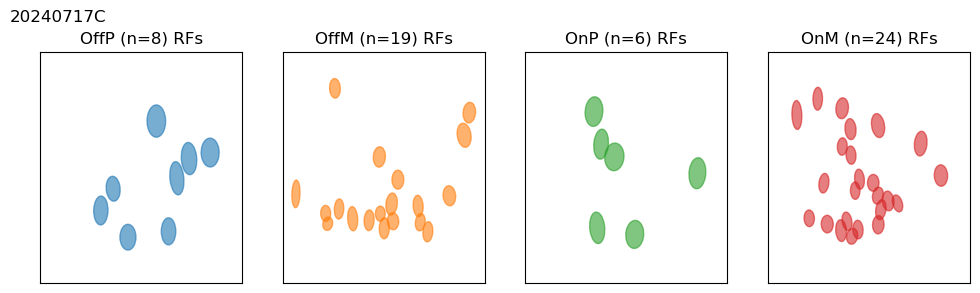

In [22]:
sp.plot_type_rfs(data, sd_mult=0.8, b_zoom=True);

Luckily enough here this gets rid of obvious duplicates. What if there were still some duplicates remaining? 

Let's go back to our original set of cell IDs and use methods in the `meaqc.py` module to remove overlapping cells.

In [48]:
import importlib
importlib.reload(meaqc)
importlib.reload(so)
str_experiment = '20240717C'
d_meta = {'str_experiment': str_experiment,
          'str_algo': 'kilosort2.5',
          'paramsfile': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5.params',
          'dataset_name': 'kilosort2.5',
          'str_classification': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/vr_kilosort2.5.classification.txt',
          'ls_RGC_labels': ['OffP', 'OffM', 'OnP', 'OnM'],
          'ls_filenames': ['data014'],
          'ls_noise_filenames': ['data012'],
          'paramsmatfile': '/Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5_params.mat'}
data = so.SpikeOutputs(**d_meta)
data.load_sta_from_params()

Loading STA from /Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5.params...
Loaded STA for 458 cells.
Loading STA params from /Volumes/Vyom MEA/analysis/20240717C/chunk3/kilosort2.5/kilosort2.5_params.mat...
Loaded STA params for 458 cells.


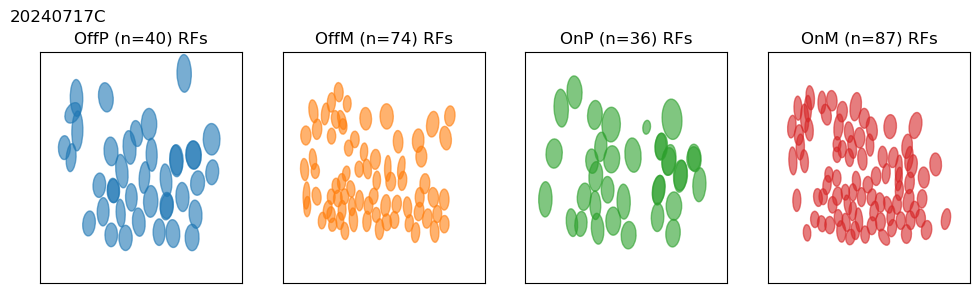

In [49]:
sp.plot_type_rfs(data, sd_mult=0.8, b_zoom=True);

Let's just focus on OnP which has clear duplicates. You can use these methods for other types in the same way.

First, we need to find a threshold distance between cell centers. For cell pairs with distances below that threshold, we will only keep one of them.

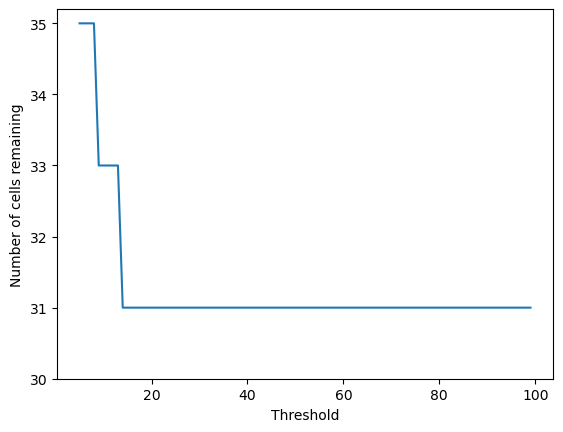

In [ ]:
# find_dup_thresh takes in SpikeOutputs object, cell type label, and list of thresholds to check
meaqc.find_dup_thresh(data, 'OnP', np.arange(5, 100))

Great, this is what we like to see. For a threshold of ~20, kicking out duplicates removes ~4 cells, after which increasing threshold keeps number of cells constant. We can use `meaqc.remove_dups` and a threshold of 20 to remove the overlapping cells.

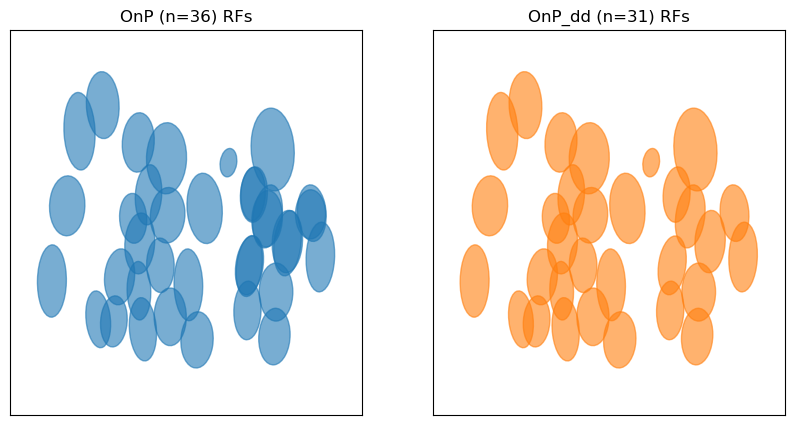

In [ ]:
removed_ids, kept_ids = meaqc.remove_dups(data, 20, 'OnP')

We can delete the removed_ids from the SpikeOutputs object.

In [52]:
data.remove_ids(removed_ids)

Updating GOOD_CELL_IDS to 453 cells.
OffP: 40/40
OffM: 74/74
OnP: 31/36
OnM: 87/87


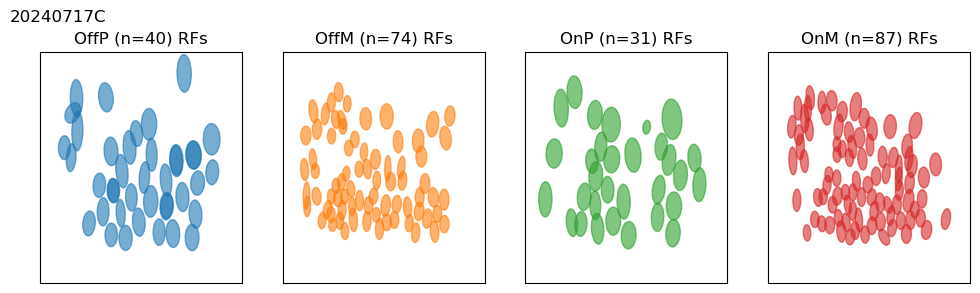

In [53]:
sp.plot_type_rfs(data, sd_mult=0.8, b_zoom=True);